In [411]:
#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as pl
%matplotlib inline
import imageio
from scipy.interpolate import interp1d

#Edge Detection
import skimage
import skimage.feature
import skimage.viewer
import sys
from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

This notebook shows the process of reading in any black/white image, conducting the necessary pre-processing, and then reordering the x- and y- arrays in oscillating fashion using the optimal method found in the previous notebook "Oscillation Optimization". 

**Step One: Edge Detection**

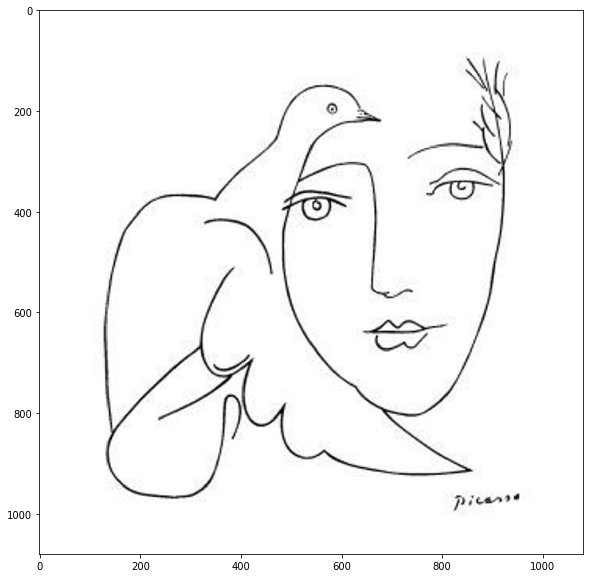

In [437]:
working_image = imageio.imread('Paintings/Face_Picasso.jpg')
plt.figure(figsize = (10,10))
#plt.title('"Face - Line Drawing"\nPicasso')
plt.imshow(working_image)

In [413]:
#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    
    bw_mask = gray_img[:, :,] < thresh
    gray_img[bw_mask] = 0
    gray_img[~bw_mask] = 1
    
    return gray_img

In [414]:
#Now let's write a formula that will take in an image, convert to binary, detect the edges, and then return the edges as a ector
def line_vectors(img,thresh=130):
    bw_img = make_bw(img,thresh)
    edge_image = scharr(bw_img)
    
    row_vals = []
    col_vals = []
    for i in range(len(edge_image)):
        for j in range(len(edge_image[i])):
            if edge_image[i][j]>0:
                row_vals.append(i)
                col_vals.append(j)
    
    return list(reversed(col_vals)),row_vals

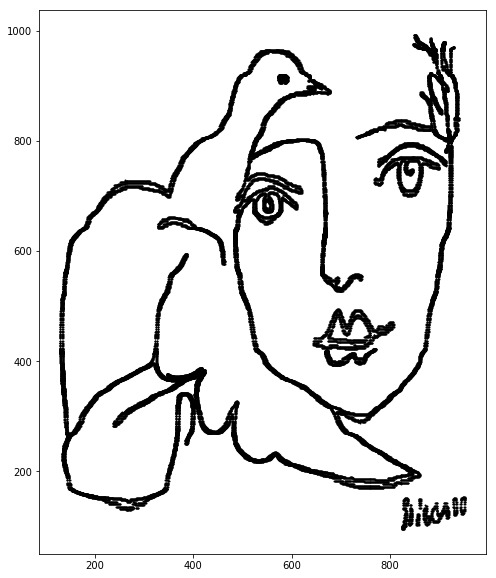

In [415]:
x_vals, y_vals = line_vectors(working_image)
plt.figure(figsize = (8,10))
plt.scatter(x_vals,y_vals,s=1,color='k')
plt.show()

Now, let's create a whole new vector - this one a list of index values, such that every x/y pair will have a unique index value.

In [416]:
index_vals = []
index_val = 0
for i in x_vals:
    index_vals.append(index_val)
    index_val += 1
    
#And let's stitch this all up into a single dataframe
val_df = pd.DataFrame({
    'index':index_vals,
    'x_vals':x_vals,
    'y_vals':y_vals})

val_array = np.array(val_df)

What do the above arrays look like, plotted relative to the index array?

Text(0.5,1,'X Values vs. Index (Narrower View)')

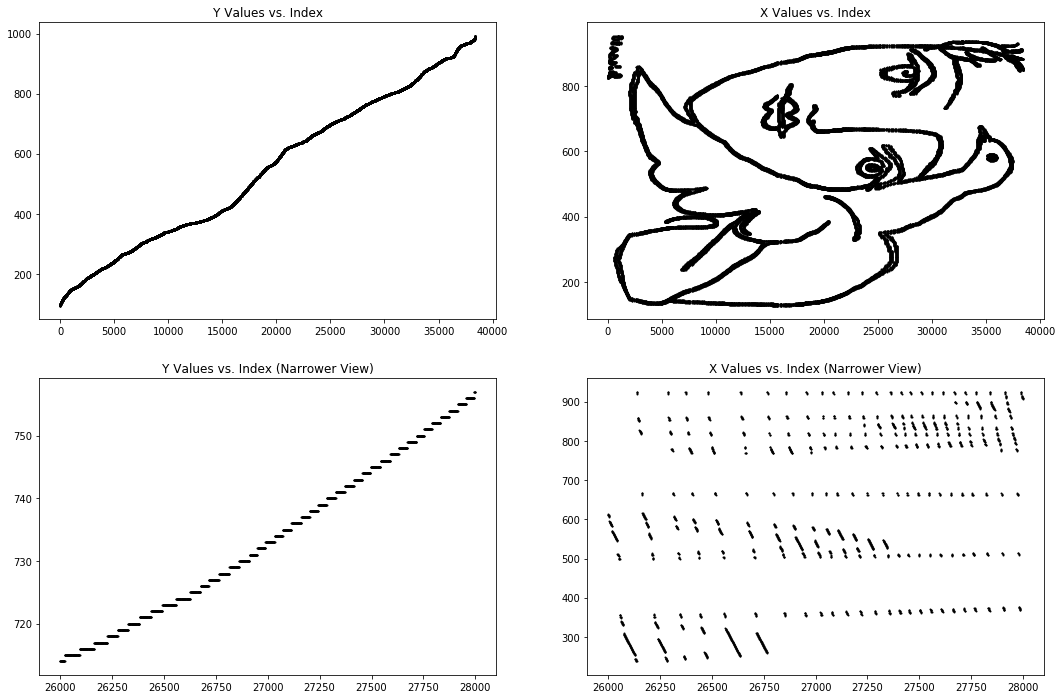

In [420]:
fig, axs = plt.subplots(2,2,figsize=(18,12))
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.suptitle("Two new arrays (X- and Y-values) plotted against Index")

axs[0,0].scatter(index_vals,y_vals,s=1,color='k')
axs[0,0].set_title("Y Values vs. Index")
axs[0,1].scatter(index_vals,x_vals,s=1,color='k')
axs[0,1].set_title("X Values vs. Index")

axs[1,0].scatter(index_vals[26000:28000],y_vals[26000:28000],s=1,color='k')
axs[1,0].set_title("Y Values vs. Index (Narrower View)")
axs[1,1].scatter(index_vals[26000:28000],x_vals[26000:28000],s=1,color='k')
axs[1,1].set_title("X Values vs. Index (Narrower View)")

Decomposing each image into a vector of xs and ys results in two arrays, each of each has no duplicate x/y pairs. While it's hard to tell from this image, the "X-Values" image on the right actually consists of lots of little dots/lines of dots, each of which is unique to each index value: there is only one Y-value (or in this case "X-value") for every index value. 

This obviates the problem we had before: of how to interplolate an image with multiple y values for every x value. 

We can now begin interpolating. What we will do is create a series of interpolating functions for the index/y pairs, and another set of interpolating functions for the index/x pairs. We will then plot these two sets of interpolating functions against each other. 

Ok! You need to make the y-adding part of the algorithm contingent on the x-values at the next step. I.e. only add y-values if there is a corresponding continuous x-value at the next step, otherwise stay the same, otherwise go in the opposite direction, otherwise add the next higher x/y pair if there is no continuous one.

The "X Values" plot isn't actually storing any information - all the information is in the Y-Values plot. Doing the above would allow both plots to convey information. 

In [351]:
def init_wave(input_array):
    val_array = np.copy(input_array)
    new_val_order = []
    
    xmin = np.min(val_array[:,1])
    xmax = np.max(val_array[:,1])
    
    #Choosing random starting points: minimum x, minimum y, random choice within that
    start_array = val_array[val_array[:,1] == xmin]
    ymin = np.min(start_array[:,2])
    start_array = start_array[start_array[:,2] == ymin]
    start_points = start_array[np.random.randint(len(start_array))]
    val_array = val_array[val_array[:,0] != start_points[0]] #Remove the (random) starting value from val_array
    new_val_order.append(start_points)
    
    prev_val = new_val_order[-1]
    prev_val_1 = prev_val[1]
    prev_val_2 = prev_val[2]
    filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
    new_xmin_1 = np.min(filtered_array_1[:,1])
    
    filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]
    new_xmin_2 = np.min(filtered_array_2[:,1])
    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
    
    y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
    y_opt_1 = filtered_array_1[:,2][y_index_1]
    y_index_2 = np.argmin(filtered_array_2[:,2] - prev_val_2)
    y_opt_2 = filtered_array_2[:,2][y_index_2]
    
    #Go with the y_opt that minimizes the difference with the previous y
    if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
        next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
        next_points = next_array[np.random.randint(len(next_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    else:
        next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
        next_points = next_array[np.random.randint(len(next_array))] #Get the next points
        new_val_order.append(next_points) #Append the next points to the new array
        val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    
    return val_array,new_val_order

In [352]:
def first_few_vals(input_array,iters=20): #used to be 10
    val_array,val_order = init_wave(input_array)
    
    new_val_order = []
    for i in val_order:
        new_val_order.append(i)
    
    for i in range(iters):
        xmin = np.min(val_array[:,1])
        xmax = np.max(val_array[:,1])

        #Initialize
        prev_vals = new_val_order[-1]
        
        prev_val_1 = prev_vals[1]
        prev_val_2 = prev_vals[2]
        
        if xmax>prev_val_1:
            filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
            filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]
            
            new_xmin_2 = np.min(filtered_array_2[:,1])
            new_xmin_1 = np.min(filtered_array_1[:,1])

            filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
            
            #This makes sure that the added y's move in an upward direction
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]>= prev_val_2)]
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]>= prev_val_2)]
                       
            y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(filtered_array_2[:,2] - prev_val_2)
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
                
        else: #This section doesn't work ideally - but it doesn't really matter since this is just for the first points
            filtered_array_1 = val_array[(val_array[:,1] == xmax)]    
            y_index_1 = np.argmin(filtered_array_1[:,2] - prev_val_2)
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
            next_points = next_array[np.random.randint(len(next_array))] #Get the next points
            new_val_order.append(next_points) #Append the next points to the new array
            val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    val_array = np.array(val_array)
    new_val_order = np.array(new_val_order)
    
    return val_array,new_val_order

In [353]:
def return_neibs(new_val_order,neibs = 2): ###used to be 5
    prev_x_vals = []
    prev_y_vals = []
    for i in range(1,neibs+1):
        prev_val = new_val_order[-i]
        prev_val_x = prev_val[1]
        prev_val_y = prev_val[2]
        
        prev_x_vals.append(prev_val_x)
        prev_y_vals.append(prev_val_y)
    
    return prev_x_vals,prev_y_vals

#def going_up(previous_neibs):
    

In [354]:
def going_up(prev_vals):
    diffs = []
    for i in range(len(prev_vals)-1):
        diff = prev_vals[i] - prev_vals[i+1]
        diffs.append(diff)
    diff_sum = np.sum(diffs)
    return diff_sum

In [355]:
#Rewrite these so that they return 2 arrays - one at the same, one at the next highest
def going_up_x_step(val_array,prev_val_1):
    filtered_array_1 = val_array[(val_array[:,1] >= prev_val_1)]
    filtered_array_2 = val_array[(val_array[:,1] > prev_val_1)]

    new_xmin_1 = np.min(filtered_array_1[:,1])
    new_xmin_2 = np.min(filtered_array_2[:,1])

    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmin_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmin_2)]
    
    return filtered_array_1,filtered_array_2

def going_down_x_step(val_array,prev_val_1):
    filtered_array_1 = val_array[(val_array[:,1] <= prev_val_1)]
    filtered_array_2 = val_array[(val_array[:,1] < prev_val_1)]
    
    new_xmax_1 = np.max(filtered_array_1[:,1])
    new_xmax_2 = np.max(filtered_array_2[:,1])    
    
    filtered_array_1 = filtered_array_1[(filtered_array_1[:,1]==new_xmax_1)]
    filtered_array_2 = filtered_array_2[(filtered_array_2[:,1]==new_xmax_2)]
    
    return filtered_array_1, filtered_array_2

In [356]:
def default_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array):
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:

            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))

            y_opt_1 = filtered_array_1[:,2][y_index_1]
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        
        else:
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
            next_points = next_array[np.random.randint(len(next_array))] #Get the next points
            new_val_order.append(next_points) #Append the next points to the new array
            val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
    
    return new_val_order,val_array

In [357]:
def going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array):
    
    old_filtered_array_1 = np.copy(filtered_array_1)
    old_filtered_array_2 = np.copy(filtered_array_2)
    
    filtered_array_1 = filtered_array_1[filtered_array_1[:,2] <= prev_val_2]
    filtered_array_2 = filtered_array_2[filtered_array_2[:,2] < prev_val_2]
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:
            
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        else:
            new_ymax = np.max(filtered_array_1[:,2])
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]==new_ymax)]
            next_points = filtered_array_1[np.random.randint(len(filtered_array_1))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    else:
        if len(filtered_array_2)>0:
            new_ymax = np.max(filtered_array_2[:,2])
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]==new_ymax)]
            next_points = filtered_array_2[np.random.randint(len(filtered_array_2))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    
        else:
            new_val_order,val_array = default_y_step(old_filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
    
    return new_val_order,val_array

In [358]:
def going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array):
    
    old_filtered_array_1 = np.copy(filtered_array_1)
    old_filtered_array_2 = np.copy(filtered_array_2)
    
    filtered_array_1 = filtered_array_1[filtered_array_1[:,2] >= prev_val_2]
    filtered_array_2 = filtered_array_2[filtered_array_2[:,2] > prev_val_2]
    
    if len(filtered_array_1)>0:
        if len(filtered_array_2)>0:
            
            y_index_1 = np.argmin(np.abs(filtered_array_1[:,2] - prev_val_2))
            y_opt_1 = filtered_array_1[:,2][y_index_1]
            
            y_index_2 = np.argmin(np.abs(filtered_array_2[:,2] - prev_val_2))
            y_opt_2 = filtered_array_2[:,2][y_index_2]

            #Go with the y_opt that minimizes the difference with the previous y
            if np.abs(y_opt_1 - prev_val_2) < np.abs(y_opt_2 - prev_val_2):
                next_array = filtered_array_1[filtered_array_1[:,2]==y_opt_1]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
            else:
                next_array = filtered_array_2[filtered_array_2[:,2]==y_opt_2]
                next_points = next_array[np.random.randint(len(next_array))] #Get the next points
                new_val_order.append(next_points) #Append the next points to the new array
                val_array = val_array[val_array[:,0] != next_points[0]] #Delete the points from the old array
        else:
            new_ymin = np.min(filtered_array_1[:,2])
            filtered_array_1 = filtered_array_1[(filtered_array_1[:,2]==new_ymin)]
            next_points = filtered_array_1[np.random.randint(len(filtered_array_1))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    else:
        if len(filtered_array_2)>0:
            new_ymin = np.min(filtered_array_2[:,2])
            filtered_array_2 = filtered_array_2[(filtered_array_2[:,2]==new_ymin)]
            next_points = filtered_array_2[np.random.randint(len(filtered_array_2))]
            new_val_order.append(next_points)
            val_array = val_array[val_array[:,0] != next_points[0]]
    
        else:
            new_val_order,val_array = default_y_step(old_filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
    
    return new_val_order,val_array

In [359]:
def y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y):
    
    #If the array recently hit y_max, we should force it to go down
    if y_max in prev_vals_y: 
        new_val_order,val_array = going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
            
    #If the array recently hit y_min, force it to go up
    elif y_min in prev_vals_y: 
        new_val_order,val_array = going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
           
    #If it's going up and less than y-max, tell it to keep going up
    elif going_up(prev_vals_y)>0:
        new_val_order,val_array = going_up_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array)
           
    #If it's going down and greater than y-min, tell it to keep going down
    elif going_up(prev_vals_y)<=0: 
        new_val_order,val_array = going_down_y_step(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array) 
        
    return new_val_order,val_array
             

In [360]:
def initialize_step(val_array,new_val_order):
    x_max = np.max(val_array[:,1])
    x_min = np.min(val_array[:,1])
    y_max = np.max(val_array[:,2])
    y_min = np.min(val_array[:,2])
        
    prev_vals_x,prev_vals_y = return_neibs(new_val_order)
    prev_val_1 = prev_vals_x[0]
    prev_val_2 = prev_vals_y[0]
    
    return x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2
    

In [361]:
def double_wave_form(input_array):
    val_array,start_points = first_few_vals(input_array,iters=10)
    
    new_val_order = []
    for i in start_points:
        new_val_order.append(i)
    
    while len(val_array)>0:
        x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)
        
        while x_max > prev_val_1 and len(val_array)>0:
            filtered_array_1,filtered_array_2 = going_up_x_step(val_array,prev_val_1)
            new_val_order,val_array = y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y)   
            x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)
           
            #if prev_val_1 == x_max:
            if x_max in prev_vals_x: #Change the above so that it goes down if x_max in previous few x_vals
                while x_min < prev_val_1 and len(val_array)>0:
                    filtered_array_1,filtered_array_2 = going_down_x_step(val_array,prev_val_1)
                    new_val_order,val_array = y_step_sequence(filtered_array_1,filtered_array_2,prev_val_1,prev_val_2,new_val_order,val_array,y_min,y_max,prev_vals_y)
                    
                    if len(val_array)>0: ###
                        x_max,x_min,y_max,y_min,prev_vals_x,prev_vals_y,prev_val_1,prev_val_2 = initialize_step(val_array,new_val_order)

        #For now, let's just add the remaining values to the array
        for i in val_array:
            new_val_order.append(i)
            val_array = val_array[val_array[:,0] != i[0]] #Remove the item from val array
            
    x_vals = []
    y_vals = []
    new_index = []
    j = 0
    for i in new_val_order:
        x_vals.append(i[1])
        y_vals.append(i[2])
        new_index.append(j)
        j += 1
        
    #And let's stitch this all up into a single dataframe
    new_df = pd.DataFrame({
        'index':new_index,
        'x_vals':x_vals,
        'y_vals':y_vals})
            
    return new_df,x_vals,y_vals

In [362]:
sorted_df, sorted_x, sorted_y = double_wave_form(val_array)
len(sorted_df)

38385

Text(0.5,1,'Y Values vs. Index (Narrower View)')

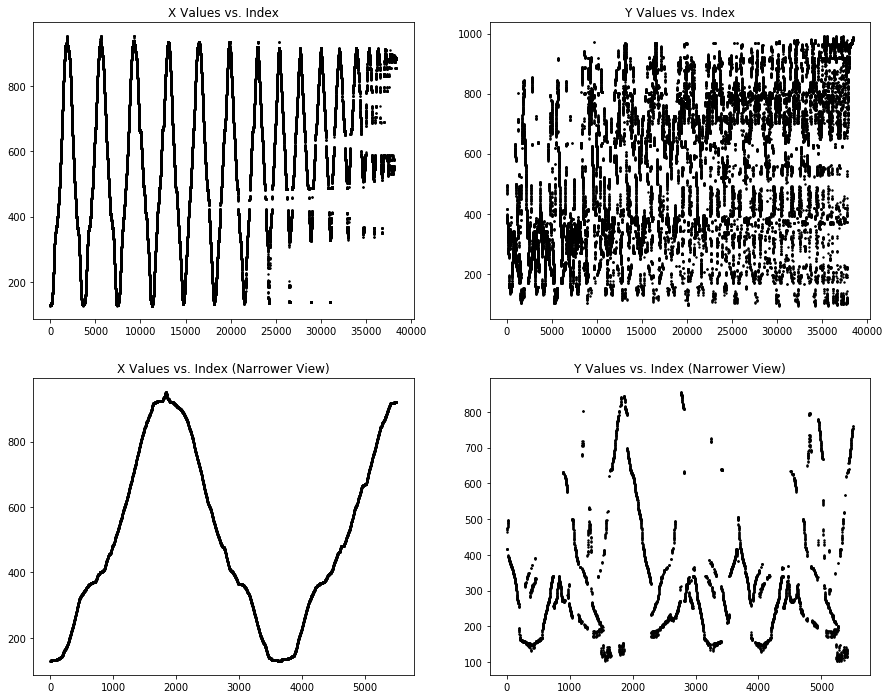

In [422]:
fig, axs = plt.subplots(2,2,figsize=(15,12))
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.suptitle("Two new sorted arrays (X- and Y-values) plotted against Index")

axs[0,0].scatter(sorted_df['index'],sorted_df['x_vals'],s=2,color='k')
axs[0,0].set_title("X Values vs. Index")
axs[0,1].scatter(sorted_df['index'],sorted_df['y_vals'],s=2,color='k')
axs[0,1].set_title("Y Values vs. Index")

axs[1,0].scatter(small_array[:,0],small_array[:,1],s=2,color='k')
axs[1,0].set_title("X Values vs. Index (Narrower View)")
axs[1,1].scatter(small_array[:,0],small_array[:,2],s=2,color='k')
axs[1,1].set_title("Y Values vs. Index (Narrower View)")

Text(0.5,1,'Y Values vs. Index')

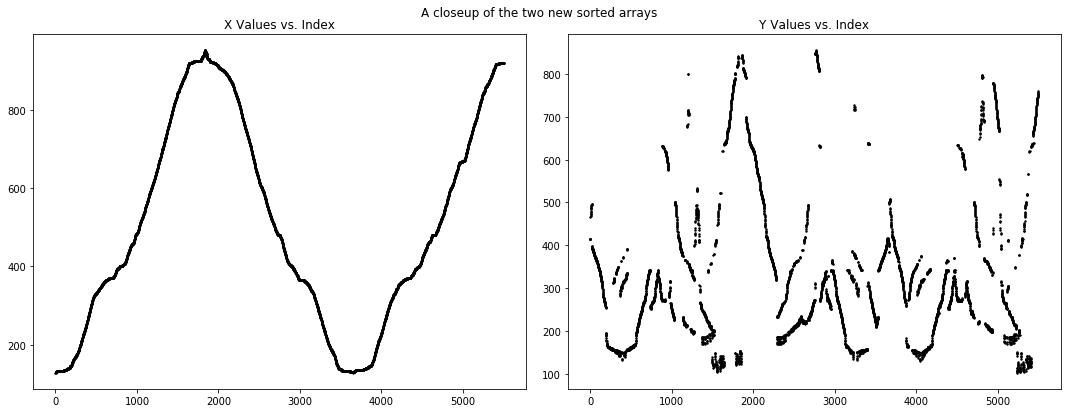

In [385]:
xy_array = np.array(sorted_df)
small_array = xy_array[0:5500]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("A closeup of the two new sorted arrays")

ax1.scatter(small_array[:,0],small_array[:,1],s=2,color='k')
ax1.set_title("X Values vs. Index")
ax2.scatter(small_array[:,0],small_array[:,2],s=2,color='k')
ax2.set_title("Y Values vs. Index")

As we can see, this new approach seems to isolate various fairly-continuous segments from the array of y-values. This is potentially something that could be approximated with a set of interpolating functions. 

What it seems like is the y-function could be well-approximated by a series of overlapping functions. What we could do is: string together values that are close together in both index- and y-value together, and then plot them. 

In [365]:
short_array = xy_array[2000:3000]

In [366]:
def euc_dist(v1,v2):
    v1_x = v1[0]
    v2_x = v2[0]
    
    v1_y = v1[2]
    v2_y = v2[2]
    
    x_delta = np.abs(v1_x - v2_x)
    y_delta = np.abs(v1_y - v2_y)
    
    z_delta = np.sqrt(x_delta**2 + y_delta**2)
    
    return z_delta
    

In [367]:
def create_clusters(input_array,thresh_distance=20):
    
    val_array = np.copy(input_array)
    starting_val = val_array[0]
    
    clusters = []
    clusters.append([starting_val])
    
    val_array = val_array[val_array[:,0] != starting_val[0]]

    for i in val_array:
        if euc_dist(i,clusters[-1][-1]) < thresh_distance:
            clusters[-1].append(i)
            
        elif len(clusters)>1 and euc_dist(i,clusters[-2][-1]) < thresh_distance:
            clusters[-2].append(i)     
        
        elif len(clusters)>2 and euc_dist(i,clusters[-3][-1]) < thresh_distance:
            clusters[-3].append(i) 
        
        else:
            clusters.append([i])
    
    clusters_list = []
    for i in clusters:
        clusters_list.append(np.array(i))

    return clusters_list

In [368]:
clusters_list = create_clusters(xy_array)

lens_list = [len(i) for i in clusters_list]

(0, 50)

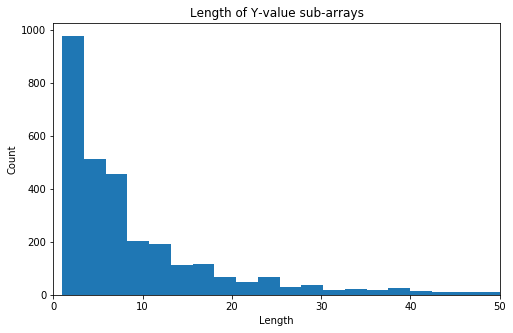

In [369]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(lens_list,bins=200)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
ax.set_title('Length of Y-value sub-arrays')
ax.set_xlim([0,50])

In [370]:
def plot_cluster(clusters_list,number):
    plt.scatter(clusters_list[number][:,0],clusters_list[number][:,2],s=2,color='k')
    #plt.show()

In [386]:
short_clusters = []
mid_clusters = []
long_clusters = []
v_long_clusters = []

for i in clusters_list:
    if len(i)>10:
        short_clusters.append(i)
    if len(i)>20:
        mid_clusters.append(i)
    if len(i)>50:
        long_clusters.append(i)
    if len(i)>100:
        v_long_clusters.append(i)

In [392]:
def unravel_clusters_list(clusters_list):
    new_list = []
    for i in clusters_list:
        for j in i:
            new_list.append(j)
    
    new_array = np.array(new_list)
    return new_array

In [393]:
short_clusters = unravel_clusters_list(short_clusters)
mid_clusters = unravel_clusters_list(mid_clusters)
long_clusters = unravel_clusters_list(long_clusters)
v_long_clusters = unravel_clusters_list(v_long_clusters)

In [396]:
plt.rcParams.update({'font.size': 16})

In [401]:
new_ind_vals_mid = []
new_x_vals_mid = []
new_y_vals_mid = []

new_ind_vals_long = []
new_x_vals_long = []
new_y_vals_long = []

new_ind_vals_vlong = []
new_x_vals_vlong = []
new_y_vals_vlong = []

for i in mid_clusters:
    new_ind_vals_mid.append(i[0])
    new_x_vals_mid.append(i[1])
    new_y_vals_mid.append(i[2])

mid_df = pd.DataFrame({
    'index':new_ind_vals_mid,
    'X_Vals': new_x_vals_mid,
    'Y_Vals': new_y_vals_mid})

for i in long_clusters:
    new_ind_vals_long.append(i[0])
    new_x_vals_long.append(i[1])
    new_y_vals_long.append(i[2])

long_df = pd.DataFrame({
    'index':new_ind_vals_long,
    'X_Vals': new_x_vals_long,
    'Y_Vals': new_y_vals_long})

for i in v_long_clusters:
    new_ind_vals_vlong.append(i[0])
    new_x_vals_vlong.append(i[1])
    new_y_vals_vlong.append(i[2])

vlong_df = pd.DataFrame({
    'index':new_ind_vals_vlong,
    'X_Vals': new_x_vals_vlong,
    'Y_Vals': new_y_vals_vlong})


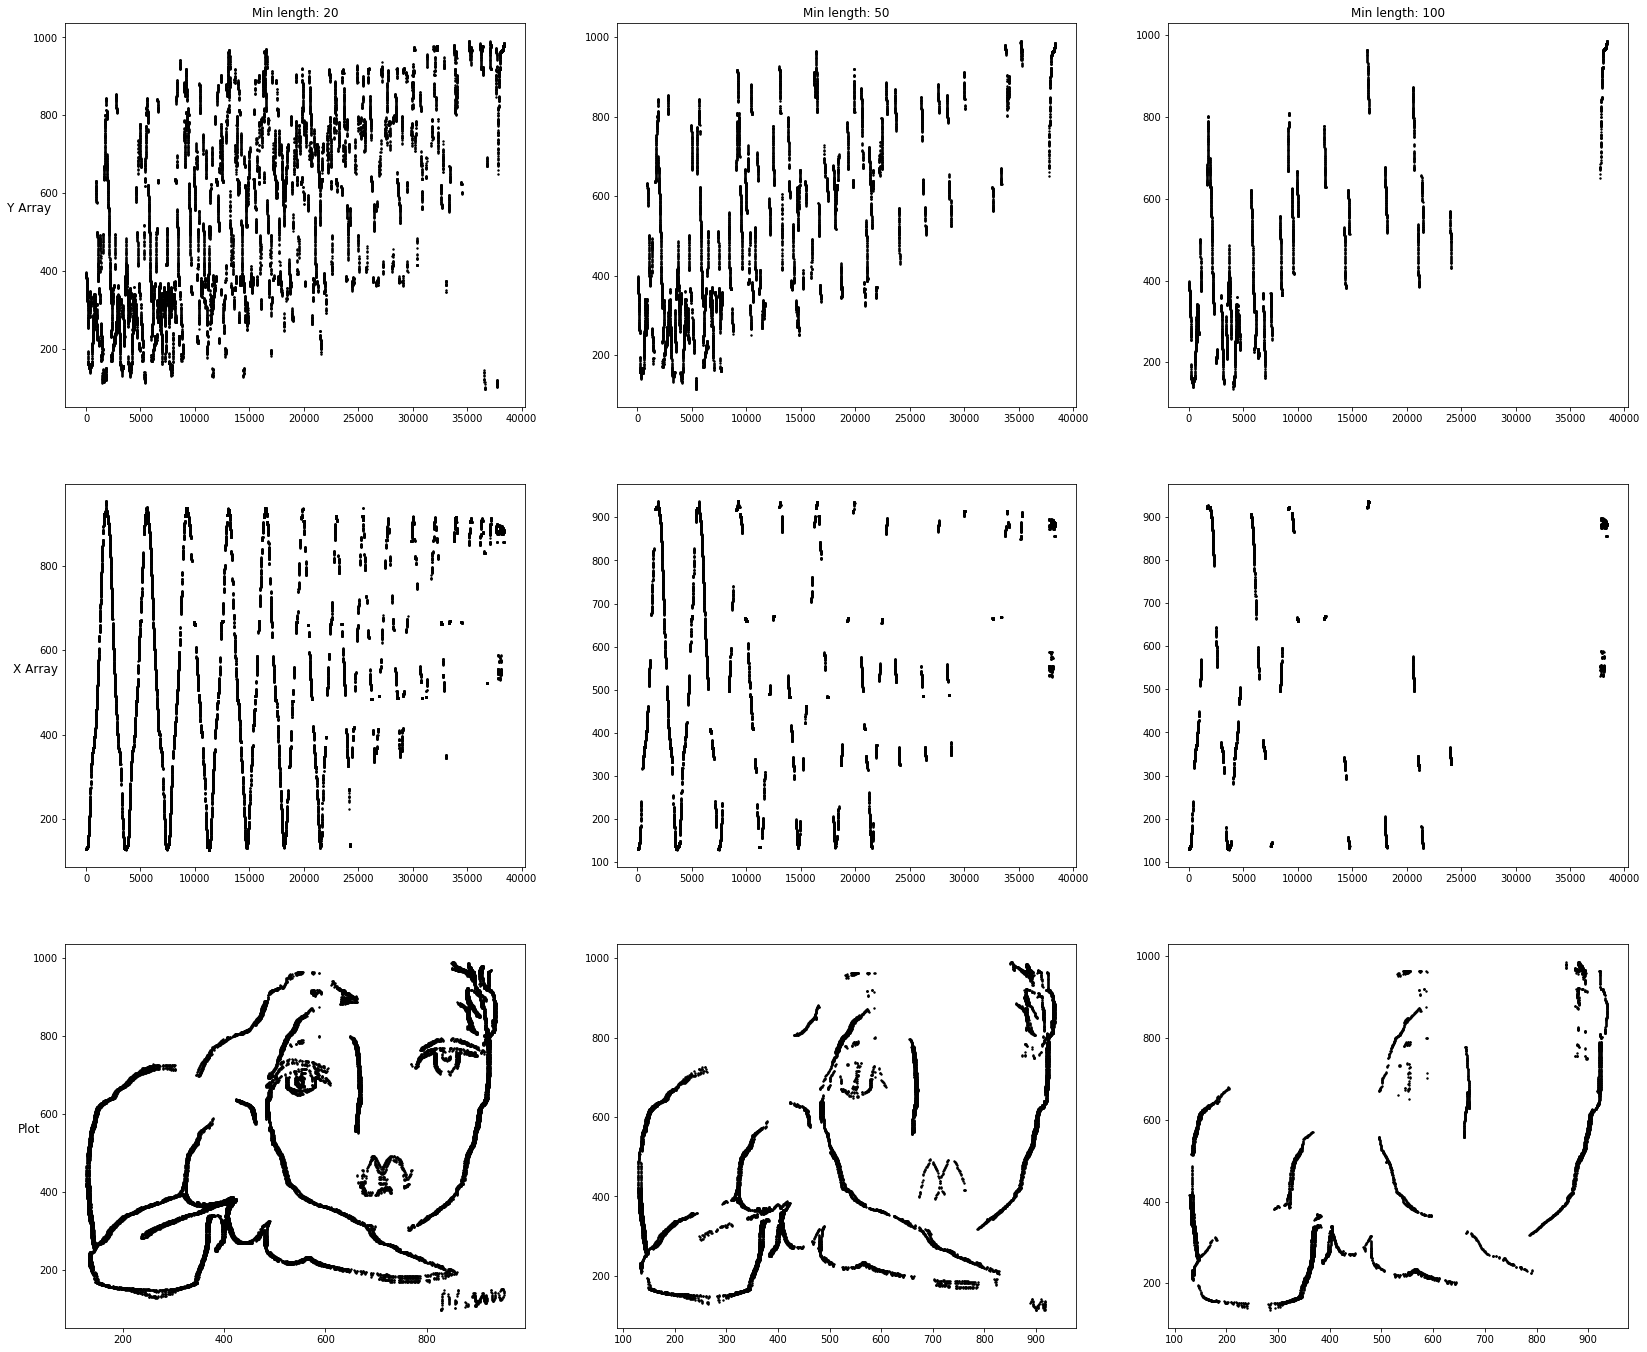

In [435]:
fig, axs = plt.subplots(3,3,figsize=(28,24))

cols = ['Min Length 20','Min Length 50','Min Length 100']
rows = ['Y Array','X Array','Plot']

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

axs[0,0].scatter(mid_clusters[:,0],mid_clusters[:,2],s=2,color='k')
axs[0,0].set_title("Min length: 20")
axs[0,1].scatter(long_clusters[:,0],long_clusters[:,2],s=2,color='k')
axs[0,1].set_title("Min length: 50")
axs[0,2].scatter(v_long_clusters[:,0],v_long_clusters[:,2],s=2,color='k')
axs[0,2].set_title("Min length: 100")

axs[1,0].scatter(mid_clusters[:,0],mid_clusters[:,1],s=2,color='k')
axs[1,1].scatter(long_clusters[:,0],long_clusters[:,1],s=2,color='k')
axs[1,2].scatter(v_long_clusters[:,0],v_long_clusters[:,1],s=2,color='k')

axs[2,0].scatter(mid_df['X_Vals'],mid_df['Y_Vals'],s=2,color='k')
axs[2,1].scatter(long_df['X_Vals'],long_df['Y_Vals'],s=2,color='k')
axs[2,2].scatter(vlong_df['X_Vals'],vlong_df['Y_Vals'],s=2,color='k')

Text(0.5,1,'Simplified Arrays plotted against one another')

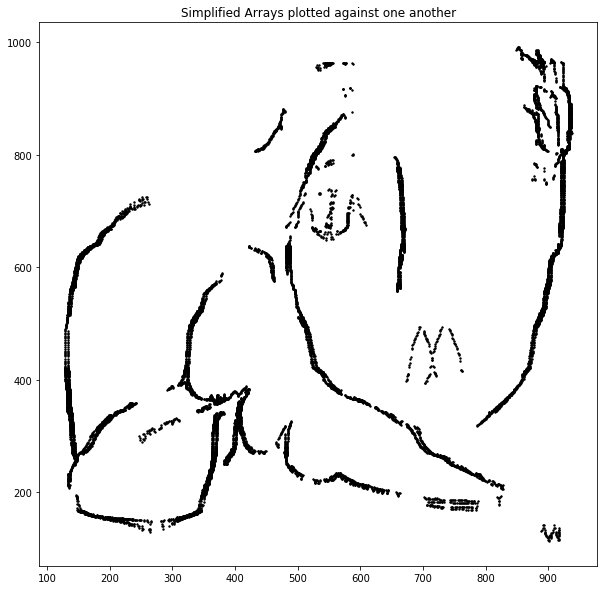

In [376]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(simple_df['X_Vals'],simple_df['Y_Vals'],s=2,color='k')
ax.set_title("Simplified Arrays plotted against one another")

Next step: Interpolate each segment, and then graph these two things with respect to one another. 

In [378]:
def index_value_split(cluster_array):
    index_vals = []
    x_vals = []
    y_vals = []
    for i in cluster_array:
        index_vals.append(i[:,0])
        x_vals.append(i[:,1])
        y_vals.append(i[:,2])
    
    return index_vals,x_vals,y_vals
        

In [379]:
ind_vals,x_vals,y_vals = index_value_split(long_clusters)

In [380]:
f_1 = interp1d(np.array(ind_vals[1]), np.array(x_vals[1]), kind='cubic',fill_value="extrapolate")

In [381]:
def gen_interp_funs(index_arrays,sub_arrays):
    interp_funs = [] #This will be an array of separate interpolation functions
    for i in range(len(sub_arrays)):
        f_i = interp1d(index_arrays[i], sub_arrays[i], kind='cubic',fill_value="extrapolate")
        interp_funs.append(f_i)
    
    return interp_funs

In [382]:
def gen_interp_vals(interp_funs,index_arrays):
    calc_vals = []
    for i in range(len(index_arrays)):
        fun_iter = interp_funs[i]
        calc_val_list = [fun_iter(index_arrays[i])]
        calc_vals.append(calc_val_list)

    #Now let's stitch this all up into a single array
    calc_val_array = []
    for i in calc_vals:
        for j in i[0]:
            calc_val_array.append(j)

    index_val_array = []
    for i in index_arrays:
        for j in i:
            index_val_array.append(j)
    
    return index_val_array,calc_val_array

Text(0.5,1,'Calculated Y Values vs. Index')

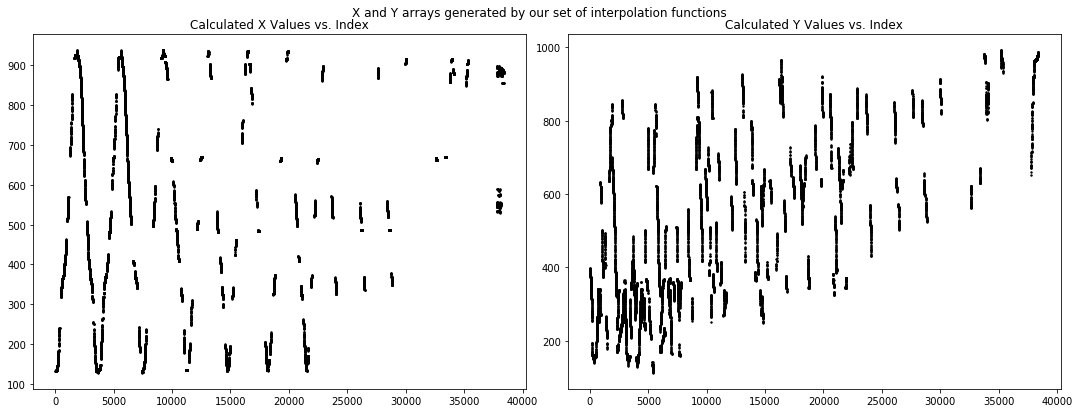

In [383]:
interp_funs_x = gen_interp_funs(ind_vals,x_vals)
index_val_array,calc_val_array_x = gen_interp_vals(interp_funs_x,ind_vals)

interp_funs_y = gen_interp_funs(ind_vals,y_vals)
index_val_array,calc_val_array_y = gen_interp_vals(interp_funs_y,ind_vals)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("X and Y arrays generated by our set of interpolation functions")

ax1.scatter(index_val_array,calc_val_array_x,s=2,color='k')
ax1.set_title("Calculated X Values vs. Index")
ax2.scatter(index_val_array,calc_val_array_y,s=2,color='k')
ax2.set_title("Calculated Y Values vs. Index")

Text(0.5,1,'Interpolant-generated arrays plotted against one another')

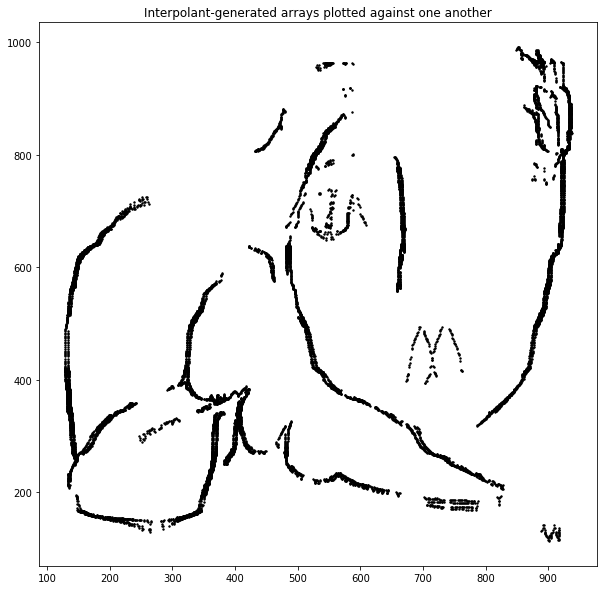

In [384]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(calc_val_array_x,calc_val_array_y,s=2,color='k')
ax.set_title("Interpolant-generated arrays plotted against one another")